In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import glob

## 
fname = r'DEEPEND_Dataset_tunas.xlsx'

df = pd.read_excel(fname,na_values=-99999)

# Getting the data without NA
tunaLarvae = df['Th_NN500'].dropna()
idx = np.where(tunaLarvae != np.nan)
sal = df['Salinity'][idx[0][:]].fillna(method='ffill')

# Removing all data based on the idx of tunaLarvae and filling the NaN regions using previous values
# removing values where salinity is greater than 40 for all variables
lat = df['Latitude (DD)'][idx[0][:]].fillna( method ='ffill') 
lat = lat[sal < 40]
lon = df['Longitude (DD)'][idx[0][:]].fillna( method ='ffill') 
lon = lon[sal < 40]
date = df['Collection date'][idx[0][:]].fillna( method ='ffill') 
date = date[sal < 40]
sst = df['SST (°C)'][idx[0][:]].fillna( method ='ffill') 
sst = sst[sal < 40]
ssh = df['SSHA (cm)'][idx[0][:]].fillna( method ='ffill') 
ssh = ssh[sal < 40]

tunaLarvae = tunaLarvae[sal < 40]
tuna = np.zeros((tunaLarvae.shape[0],1))
tuna[:,0] = tunaLarvae
sal = sal[sal < 40]

#################### 
Var_b = np.zeros((lat.shape[0],3))
Var_b[:,0] = sst 
Var_b[:,1] = ssh 
Var_b[:,2] = sal 

Text(0.5, 0, 'time steps')

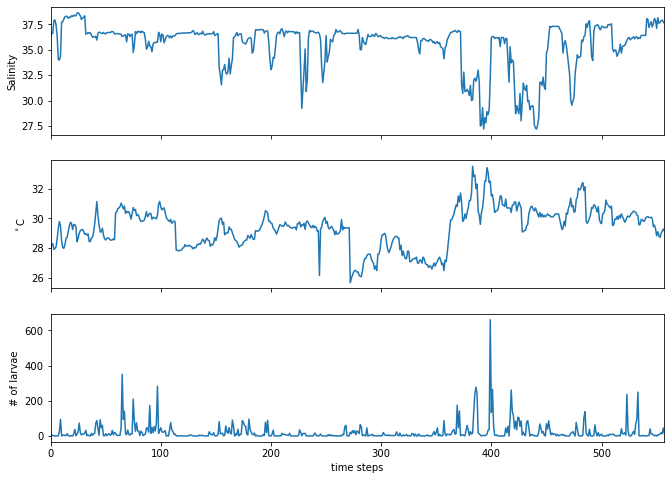

In [66]:
fig, (ax0, ax1, ax2) = plt.subplots(
    figsize=(11, 8),
    nrows=3,
    sharex=True,
)

sal.plot(ax=ax0);ax0.set_ylabel('Salinity')
sst.plot(ax=ax1);ax1.set_ylabel('$^\circ$C')
tunaLarvae.plot(ax=ax2);ax2.set_ylabel('# of larvae');ax2.set_xlabel('time steps')

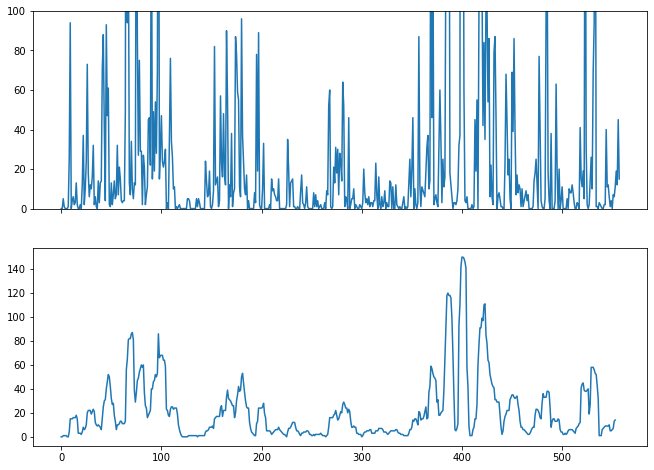

In [67]:
#%conda install bottleneck
import bottleneck as bn

def bn_mov_mean(data,width):
    return bn.move_mean(a=data,window=width,min_count = 1)

tunaSmooth = bn_mov_mean(tunaLarvae,8)

tunaVec = np.vectorize(np.int)
tunaSmooth = tunaVec(tunaSmooth)


fig, (ax0, ax1) = plt.subplots(
    figsize=(11, 8),
    nrows=2,
    sharex=True,
)
ax0.plot(tunaLarvae);ax0.set_ylim(0,100)
ax1.plot(tunaSmooth)

In [107]:
from sklearn.model_selection import train_test_split

nData = 300
seed = 20

var_train, var_validation, tuna_train, tuna_validation = train_test_split(Var_b[:nData,:], tunaSmooth[:nData], test_size=0.25, random_state=seed) 

In [108]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
#{'n_estimators': [10, 20], 'max_features': [1,2]},
{'bootstrap': [True], 'n_estimators': [1, 2], 'max_features': [1,2]},
]

forest_reg = RandomForestRegressor()

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


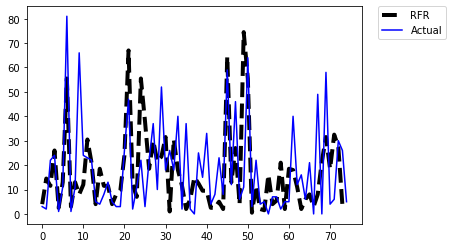

In [109]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=2)

grid_search.fit(var_train, tuna_train)

tuna_val = grid_search.predict(var_validation)

plt.plot(range(0,len(tuna_val)),tuna_val,'k--',linewidth=4,label="RFR")
plt.plot(range(0,len(tuna_validation)),tuna_validation,'b',label="Actual")  
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [110]:
grid_search.best_estimator_.feature_importances_

array([0.50381019, 0.18425695, 0.31193286])

In [111]:
# prediction on the training dataset
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(tuna_validation, tuna_val))
rms
#train_accuracy = np.sum(np.abs(grid_search.predict(var_train) - tuna_train))/len(tuna_train)
#print('Accuracy on the train dataset is '+ str(train_accuracy))

17.659652695716677

In [112]:
# prediction on the validation dataset
val_accuracy = np.sum(np.abs(grid_search.predict(var_validation)-tuna_validation))/len(tuna_validation)
print('Accuracy on the validation dataset is '+ str(val_accuracy))

Accuracy on the validation dataset is 12.246666666666666


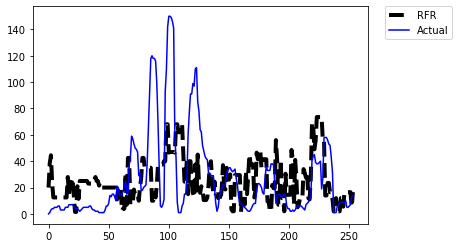

In [113]:
tuna_val = grid_search.predict(Var_b[nData:,:])

plt.plot(range(0,len(tuna_val)),tuna_val,'k--',linewidth=4,label="RFR")
plt.plot(range(0,len(tunaSmooth[nData:])),tunaSmooth[nData:],'b',label="Actual")  
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [114]:
rms = sqrt(mean_squared_error(tunaSmooth[nData:], tuna_val))
rms

33.528854068072626